In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow import keras

2026-01-03 18:25:21.506922: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-03 18:25:39.606984: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-03 18:25:46.802824: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/workspaces/SkinCancerCapstone/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## Loading Images

In [3]:
from tensorflow.keras.preprocessing.image import load_img 

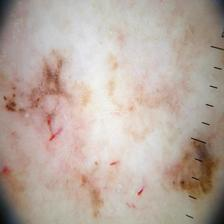

In [4]:
path = './data/train/malignant'
name = '2.jpg'
fullname = path + '/' + name
load_img(fullname)

Usually we resize images. This is how a network will see these images:

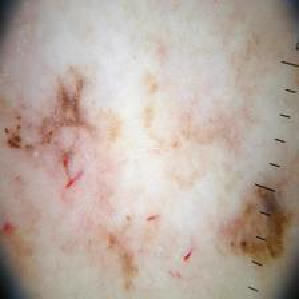

In [5]:
load_img(fullname, target_size=(299, 299))

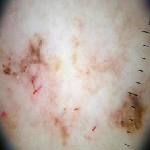

In [6]:
load_img(fullname, target_size=(150, 150))

## Pre-Trained Neural Network

Let's apply a pre-trained neural network with imagenet classes.

We'll use Xception, but any other architecture will work as well.

Check here for a list of available models:

* https://keras.io/api/applications/
* https://www.tensorflow.org/api_docs/python/tf/keras/applications


We'll need to import 3 things:

* the model itself (`Xception`)
* the `preprocess_input` function that takes an image and prepares it
* the `decode_predictions` that converts the predictions of the model into human-readable classes

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.resnet50 import decode_predictions

Let's load the model. The pre-trained model expects 299x299 input

In [8]:
model = ResNet50(
    weights='imagenet',
    input_shape=(224, 224, 3)
)

2026-01-03 18:26:15.202434: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Next,

* we load the image using the `load_img` function
* convert it to a numpy array
* make it a batch of one example

In [9]:
img = load_img(fullname, target_size=(224, 224))
x = np.array(img)
x.shape

(224, 224, 3)

In [10]:
X = np.array([x])
X.shape

(1, 224, 224, 3)

We're ready!

Next, we will:

* prepare the input
* do the predictions
* convert the predictions into a human-readable format

In [11]:
X = preprocess_input(X)

In [12]:
pred = model.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [13]:
pred.shape

(1, 1000)

In [14]:
pred[0, :10]

array([1.3607877e-05, 2.9639612e-04, 1.4250560e-01, 1.9079324e-02,
       2.6766409e-03, 1.1956144e-02, 1.3873477e-02, 1.1043297e-05,
       3.7097830e-05, 5.2853262e-05], dtype=float32)

In [15]:
decode_predictions(pred)

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[[('n01484850', 'great_white_shark', np.float32(0.1425056)),
  ('n03920288', 'Petri_dish', np.float32(0.14160052)),
  ('n07734744', 'mushroom', np.float32(0.10626588)),
  ('n02219486', 'ant', np.float32(0.07031386)),
  ('n02799071', 'baseball', np.float32(0.0687281))]]

Not quite what we wanted... Let's train our own model

## Transfer learning

Instead of loading each image one-by-one, we can use a data generator. Keras will use it for loading the images and pre-processing them

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

We'll use smaller images - it'll be faster

In [17]:
image_size = (150, 150)
batch_size = 32

Let's get train data:

In [18]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_ds = train_gen.flow_from_directory(
    "data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 2637 images belonging to 2 classes.


And validation:

In [19]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "data/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 660 images belonging to 2 classes.


For fine-tuning, we'll use `Xception` with small images (150x150)

In [20]:
base_model = ResNet50(
    weights='imagenet',
    input_shape=(150, 150, 3),
    include_top=False
)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Let's add a small neural net on top of that: just one layer with 10 neurons (there are 10 classes we want to predict)

In [21]:
inputs = keras.Input(shape=(150, 150, 3))

base = base_model(inputs, training=False)
vector = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(2)(vector)

model = keras.Model(inputs, outputs)

Now we specify the learning rate and compile the model. After that, it's ready for training

In [22]:
learning_rate = 0.01

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

Let's train now for 10 epochs:

In [23]:
history = model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20


2026-01-03 18:27:44.596863: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 46080000 exceeds 10% of free system memory.
2026-01-03 18:27:44.631452: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 48570368 exceeds 10% of free system memory.
2026-01-03 18:27:44.651077: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 47316992 exceeds 10% of free system memory.
2026-01-03 18:27:44.696200: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 47316992 exceeds 10% of free system memory.
2026-01-03 18:27:44.763963: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 47316992 exceeds 10% of free system memory.


83/83 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8111 - loss: 0.8214 - val_accuracy: 0.8561 - val_loss: 0.4049
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 136s 980ms/step - accuracy: 0.8677 - loss: 0.4103 - val_accuracy: 0.8182 - val_loss: 0.8109
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 984ms/step - accuracy: 0.8495 - loss: 0.6665 - val_accuracy: 0.8515 - val_loss: 0.6253
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 988ms/step - accuracy: 0.8946 - loss: 0.3688 - val_accuracy: 0.8561 - val_loss: 0.6910
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.9060 - loss: 0.2897 - val_accuracy: 0.8455 - val_loss: 0.9122
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 981ms/step - accuracy: 0.8953 - loss: 0.3737 - val_accuracy: 0.8545 - val_loss: 0.7961
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9139 - loss: 0.2829 - val_accuracy: 0.8818 - val_loss: 0.5327
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 990ms/step - accuracy: 0.9245 - loss: 0.2017 - val_accuracy: 0.8758 - v

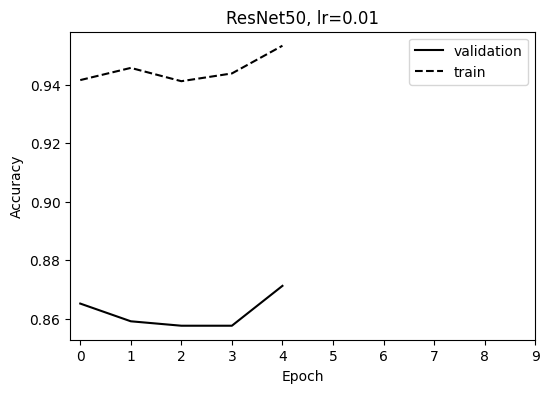

In [59]:
plt.figure(figsize=(6, 4))

epochs = history.epoch
val = history.history['val_accuracy']
train = history.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('ResNet50, lr=0.01')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(np.arange(10))

plt.legend()


plt.savefig('resnet_v1_0_01.svg')

plt.show()

0.01 is not necessarily the best learning rate, so we should experiment with 0.001 and 0.0001.

To make it easier for us, let's make a function for defining our model:

In [24]:
def make_model(learning_rate):
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)
    outputs = keras.layers.Dense(2)(vector)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

Watching metrics this way is not convenient, so let's create a special callback for that

In [60]:
model = make_model(learning_rate=0.001)
history_0_001 = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 983ms/step - accuracy: 0.7888 - loss: 0.4612 - val_accuracy: 0.8455 - val_loss: 0.3194
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8646 - loss: 0.3167 - val_accuracy: 0.8606 - val_loss: 0.3046
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8714 - loss: 0.2829 - val_accuracy: 0.8545 - val_loss: 0.3179
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.8824 - loss: 0.2533 - val_accuracy: 0.8636 - val_loss: 0.2916
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 966ms/step - accuracy: 0.8912 - loss: 0.2417 - val_accuracy: 0.8773 - val_loss: 0.2795


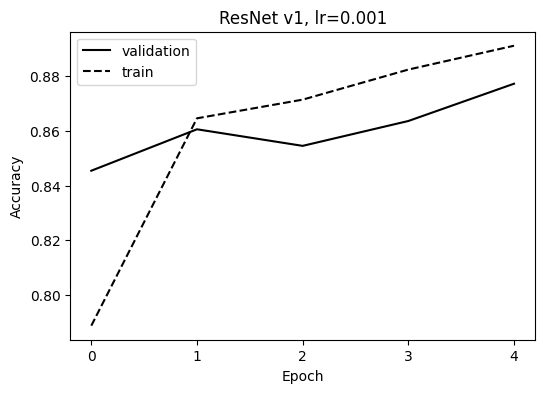

In [63]:
plt.figure(figsize=(6, 4))

epochs = history_0_001.epoch
val = history_0_001.history['val_accuracy']
train = history_0_001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('ResNet v1, lr=0.001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('resnet_v1_0_001.svg')

plt.show()

In [64]:
model = make_model(learning_rate=0.0001)
history_0_0001 = model.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.6822 - loss: 0.6408 - val_accuracy: 0.7409 - val_loss: 0.5235
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.7710 - loss: 0.4705 - val_accuracy: 0.7985 - val_loss: 0.4334
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 972ms/step - accuracy: 0.8055 - loss: 0.4135 - val_accuracy: 0.8061 - val_loss: 0.4011
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8157 - loss: 0.3850 - val_accuracy: 0.8409 - val_loss: 0.3751
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 969ms/step - accuracy: 0.8282 - loss: 0.3642 - val_accuracy: 0.8470 - val_loss: 0.3571


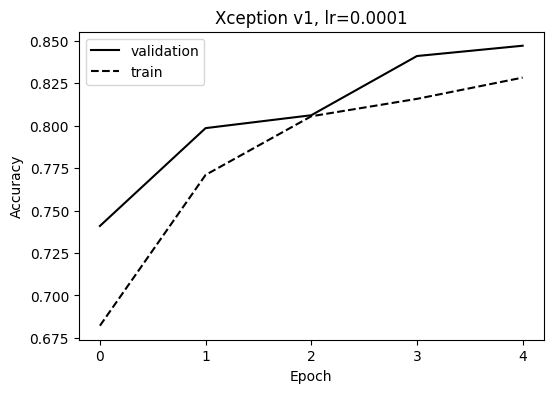

In [65]:
plt.figure(figsize=(6, 4))

epochs = history_0_0001.epoch
val = history_0_0001.history['val_accuracy']
train = history_0_0001.history['accuracy']

plt.plot(epochs, val, color='black', linestyle='solid', label='validation')
plt.plot(epochs, train, color='black', linestyle='dashed', label='train')

plt.title('Xception v1, lr=0.0001')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()


plt.savefig('xception_v1_0_0001.svg')

plt.show()

In [68]:
epochs = np.arange(5)
val_0_01 = history.history['val_accuracy']
val_0_001 = history_0_001.history['val_accuracy']
val_0_0001 = history_0_0001.history['val_accuracy']

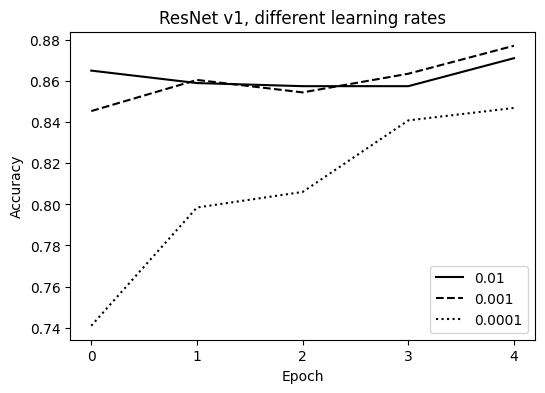

In [69]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val_0_01, color='black', linestyle='solid', label='0.01')
plt.plot(epochs, val_0_001, color='black', linestyle='dashed', label='0.001')
plt.plot(epochs, val_0_0001, color='black', linestyle='dotted', label='0.0001')


plt.title('ResNet v1, different learning rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.xticks(epochs)

plt.legend()

plt.savefig('resnet_v1_all_lr.svg')

plt.show()

The best models:

* learning rate 0.01: 0.8713
* learning rate 0.001: 0.8770
* learning rate 0.0001: 0.8470

(your results may be slightly different)

To save the best model, we can use a callback. It'll monitor the accuracy, and if it's an improvement over the previous version, it'll save the model to disk

In [70]:
model = make_model(learning_rate=0.001)

In [71]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0_001 = model.fit(train_ds, epochs=10, validation_data=test_ds, callbacks=callbacks)

Epoch 1/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.6991 - loss: 0.6266

83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 995ms/step - accuracy: 0.7816 - loss: 0.4761 - val_accuracy: 0.8455 - val_loss: 0.3587
Epoch 2/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8318 - loss: 0.3444

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 976ms/step - accuracy: 0.8468 - loss: 0.3276 - val_accuracy: 0.8545 - val_loss: 0.3166
Epoch 3/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8634 - loss: 0.2872

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 975ms/step - accuracy: 0.8703 - loss: 0.2823 - val_accuracy: 0.8667 - val_loss: 0.2998
Epoch 4/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.8886 - loss: 0.2485

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 977ms/step - accuracy: 0.8840 - loss: 0.2635 - val_accuracy: 0.8697 - val_loss: 0.2932
Epoch 5/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8961 - loss: 0.2351 - val_accuracy: 0.8636 - val_loss: 0.2961
Epoch 6/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8980 - loss: 0.2249 - val_accuracy: 0.8652 - val_loss: 0.2940
Epoch 7/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 970ms/step - accuracy: 0.9135 - loss: 0.2050 - val_accuracy: 0.8561 - val_loss: 0.3105
Epoch 8/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.9095 - loss: 0.1984

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 972ms/step - accuracy: 0.9162 - loss: 0.1940 - val_accuracy: 0.8742 - val_loss: 0.2843
Epoch 9/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.9240 - loss: 0.1813

83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9204 - loss: 0.1912 - val_accuracy: 0.8773 - val_loss: 0.2955
Epoch 10/10
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.9203 - loss: 0.1778

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 976ms/step - accuracy: 0.9215 - loss: 0.1840 - val_accuracy: 0.8879 - val_loss: 0.2784


Let's add one more layer - and a dropout between them

In [30]:
def make_model(learning_rate, droprate):
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(150, 150, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(150, 150, 3))
    
    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(2)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [ ]:
model = make_model(learning_rate=0.001, droprate=0.0)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_0_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_0 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 790ms/step - accuracy: 0.7112 - loss: 0.8438

83/83 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.8005 - loss: 0.5018 - val_accuracy: 0.8545 - val_loss: 0.3234
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8711 - loss: 0.2872 - val_accuracy: 0.8500 - val_loss: 0.3142
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.8978 - loss: 0.2345

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.8919 - loss: 0.2362 - val_accuracy: 0.8576 - val_loss: 0.3673
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.9057 - loss: 0.2123

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 981ms/step - accuracy: 0.9113 - loss: 0.2059 - val_accuracy: 0.8848 - val_loss: 0.2747
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.9293 - loss: 0.1671

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 984ms/step - accuracy: 0.9287 - loss: 0.1683 - val_accuracy: 0.8909 - val_loss: 0.2695
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 979ms/step - accuracy: 0.9427 - loss: 0.1412 - val_accuracy: 0.8788 - val_loss: 0.2881
Epoch 7/30
48/83 ━━━━━━━━━━━━━━━━━━━━ 27s 784ms/step - accuracy: 0.9446 - loss: 0.1293

In [27]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_2_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_1 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.7654 - loss: 0.5191

83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 991ms/step - accuracy: 0.8093 - loss: 0.4132 - val_accuracy: 0.8591 - val_loss: 0.2995
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 769ms/step - accuracy: 0.8622 - loss: 0.2952

83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.8745 - loss: 0.2895 - val_accuracy: 0.8818 - val_loss: 0.2799
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 968ms/step - accuracy: 0.8874 - loss: 0.2488 - val_accuracy: 0.8758 - val_loss: 0.2774
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.8972 - loss: 0.2264 - val_accuracy: 0.8636 - val_loss: 0.2796
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.9162 - loss: 0.1968

83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.9162 - loss: 0.1972 - val_accuracy: 0.8848 - val_loss: 0.2673
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9188 - loss: 0.1764 - val_accuracy: 0.8682 - val_loss: 0.2904
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 961ms/step - accuracy: 0.9295 - loss: 0.1674 - val_accuracy: 0.8848 - val_loss: 0.2779
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.9365 - loss: 0.1557

83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 969ms/step - accuracy: 0.9367 - loss: 0.1541 - val_accuracy: 0.8894 - val_loss: 0.2772
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 970ms/step - accuracy: 0.9492 - loss: 0.1354 - val_accuracy: 0.8864 - val_loss: 0.2870
Epoch 10/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 959ms/step - accuracy: 0.9412 - loss: 0.1382 - val_accuracy: 0.8879 - val_loss: 0.3002
Epoch 11/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.9598 - loss: 0.1102 - val_accuracy: 0.8742 - val_loss: 0.3145
Epoch 12/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 786ms/step - accuracy: 0.9568 - loss: 0.1094

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 991ms/step - accuracy: 0.9583 - loss: 0.1068 - val_accuracy: 0.8970 - val_loss: 0.3232
Epoch 13/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9662 - loss: 0.0923 - val_accuracy: 0.8848 - val_loss: 0.3262
Epoch 14/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 970ms/step - accuracy: 0.9757 - loss: 0.0787 - val_accuracy: 0.8818 - val_loss: 0.3581
Epoch 15/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 968ms/step - accuracy: 0.9776 - loss: 0.0647 - val_accuracy: 0.8894 - val_loss: 0.3536
Epoch 16/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9651 - loss: 0.0786 - val_accuracy: 0.8803 - val_loss: 0.4058
Epoch 17/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 968ms/step - accuracy: 0.9693 - loss: 0.0697 - val_accuracy: 0.8864 - val_loss: 0.4092
Epoch 18/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 966ms/step - accuracy: 0.9772 - loss: 0.0591 - val_accuracy: 0.8833 - val_loss: 0.3574
Epoch 19/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 967ms/step - accuracy: 0.9848 - loss: 0.0435 - val_accuracy: 0.87

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 985ms/step - accuracy: 0.9882 - loss: 0.0340 - val_accuracy: 0.9015 - val_loss: 0.4363
Epoch 27/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.9913 - loss: 0.0308 - val_accuracy: 0.8939 - val_loss: 0.4461
Epoch 28/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 978ms/step - accuracy: 0.9901 - loss: 0.0286 - val_accuracy: 0.8864 - val_loss: 0.4930
Epoch 29/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 969ms/step - accuracy: 0.9841 - loss: 0.0412 - val_accuracy: 0.8955 - val_loss: 0.4753
Epoch 30/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.9917 - loss: 0.0241 - val_accuracy: 0.8909 - val_loss: 0.4865


In [28]:
model = make_model(learning_rate=0.001, droprate=0.5)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_5_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_2 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.7176 - loss: 0.7307

83/83 ━━━━━━━━━━━━━━━━━━━━ 87s 992ms/step - accuracy: 0.7816 - loss: 0.5017 - val_accuracy: 0.8621 - val_loss: 0.3142
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.8453 - loss: 0.3406

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 974ms/step - accuracy: 0.8487 - loss: 0.3334 - val_accuracy: 0.8742 - val_loss: 0.2845
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8661 - loss: 0.2918

83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8612 - loss: 0.2897 - val_accuracy: 0.8788 - val_loss: 0.2731
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 970ms/step - accuracy: 0.8790 - loss: 0.2735 - val_accuracy: 0.8742 - val_loss: 0.2761
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 966ms/step - accuracy: 0.8889 - loss: 0.2546 - val_accuracy: 0.8515 - val_loss: 0.2937
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8946 - loss: 0.2366 - val_accuracy: 0.8682 - val_loss: 0.2862
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9003 - loss: 0.2226 - val_accuracy: 0.8697 - val_loss: 0.2758
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8942 - loss: 0.2359 - val_accuracy: 0.8727 - val_loss: 0.2701
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.9105 - loss: 0.2011 - val_accuracy: 0.8788 - val_loss: 0.2590
Epoch 10/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.9112 - loss: 0.2028

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 971ms/step - accuracy: 0.9094 - loss: 0.2040 - val_accuracy: 0.8818 - val_loss: 0.2573
Epoch 11/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 778ms/step - accuracy: 0.9105 - loss: 0.1965

83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9132 - loss: 0.1904 - val_accuracy: 0.8909 - val_loss: 0.2530
Epoch 12/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 970ms/step - accuracy: 0.9132 - loss: 0.1789 - val_accuracy: 0.8894 - val_loss: 0.2627
Epoch 13/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 772ms/step - accuracy: 0.9268 - loss: 0.1677

83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 971ms/step - accuracy: 0.9261 - loss: 0.1668 - val_accuracy: 0.8939 - val_loss: 0.2833
Epoch 14/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 973ms/step - accuracy: 0.9215 - loss: 0.1707 - val_accuracy: 0.8803 - val_loss: 0.2825
Epoch 15/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 83s 987ms/step - accuracy: 0.9245 - loss: 0.1600 - val_accuracy: 0.8833 - val_loss: 0.2820
Epoch 16/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 989ms/step - accuracy: 0.9230 - loss: 0.1693 - val_accuracy: 0.8879 - val_loss: 0.2794
Epoch 17/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9298 - loss: 0.1525 - val_accuracy: 0.8864 - val_loss: 0.2967
Epoch 18/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9393 - loss: 0.1413 - val_accuracy: 0.8894 - val_loss: 0.2707
Epoch 19/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 979ms/step - accuracy: 0.9310 - loss: 0.1546 - val_accuracy: 0.8909 - val_loss: 0.2883
Epoch 20/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9443 - loss: 0.1324 - val_accuracy: 0.8833 

83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9382 - loss: 0.1355 - val_accuracy: 0.8955 - val_loss: 0.2905
Epoch 22/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.9450 - loss: 0.1275 - val_accuracy: 0.8758 - val_loss: 0.3007
Epoch 23/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 973ms/step - accuracy: 0.9378 - loss: 0.1435 - val_accuracy: 0.8833 - val_loss: 0.3077
Epoch 24/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 980ms/step - accuracy: 0.9454 - loss: 0.1243 - val_accuracy: 0.8909 - val_loss: 0.3209
Epoch 25/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 977ms/step - accuracy: 0.9553 - loss: 0.1099 - val_accuracy: 0.8803 - val_loss: 0.3141
Epoch 26/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.9507 - loss: 0.1071 - val_accuracy: 0.8924 - val_loss: 0.3400
Epoch 27/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9522 - loss: 0.0994 - val_accuracy: 0.8864 - val_loss: 0.3460
Epoch 28/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 980ms/step - accuracy: 0.9568 - loss: 0.1081 - val_accuracy: 0.8773 

In [29]:
model = make_model(learning_rate=0.001, droprate=0.8)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v2_0_8_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_3 = model.fit(train_ds, epochs=30, validation_data=test_ds, callbacks=callbacks)

Epoch 1/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6595 - loss: 1.1881

83/83 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.7224 - loss: 0.7554 - val_accuracy: 0.8455 - val_loss: 0.3626
Epoch 2/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.7672 - loss: 0.4783

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 984ms/step - accuracy: 0.7854 - loss: 0.4408 - val_accuracy: 0.8500 - val_loss: 0.3340
Epoch 3/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.7826 - loss: 0.4415

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 985ms/step - accuracy: 0.7895 - loss: 0.4296 - val_accuracy: 0.8530 - val_loss: 0.3269
Epoch 4/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 979ms/step - accuracy: 0.8157 - loss: 0.3823 - val_accuracy: 0.8485 - val_loss: 0.3164
Epoch 5/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.8235 - loss: 0.3521

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 984ms/step - accuracy: 0.8210 - loss: 0.3596 - val_accuracy: 0.8621 - val_loss: 0.3058
Epoch 6/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.8229 - loss: 0.3567

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 980ms/step - accuracy: 0.8320 - loss: 0.3496 - val_accuracy: 0.8712 - val_loss: 0.2954
Epoch 7/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8495 - loss: 0.3303 - val_accuracy: 0.8652 - val_loss: 0.2812
Epoch 8/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 977ms/step - accuracy: 0.8506 - loss: 0.3212 - val_accuracy: 0.8697 - val_loss: 0.2855
Epoch 9/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8339 - loss: 0.3462 - val_accuracy: 0.8682 - val_loss: 0.2894
Epoch 10/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 781ms/step - accuracy: 0.8311 - loss: 0.3059

83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 984ms/step - accuracy: 0.8362 - loss: 0.3049 - val_accuracy: 0.8727 - val_loss: 0.2807
Epoch 11/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 988ms/step - accuracy: 0.8388 - loss: 0.3164 - val_accuracy: 0.8667 - val_loss: 0.2828
Epoch 12/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 141s 972ms/step - accuracy: 0.8453 - loss: 0.3211 - val_accuracy: 0.8606 - val_loss: 0.2910
Epoch 13/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 975ms/step - accuracy: 0.8460 - loss: 0.3146 - val_accuracy: 0.8667 - val_loss: 0.2790
Epoch 14/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.8491 - loss: 0.3014

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 981ms/step - accuracy: 0.8487 - loss: 0.3087 - val_accuracy: 0.8803 - val_loss: 0.2728
Epoch 15/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 983ms/step - accuracy: 0.8525 - loss: 0.2981 - val_accuracy: 0.8788 - val_loss: 0.2769
Epoch 16/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8650 - loss: 0.2792 - val_accuracy: 0.8712 - val_loss: 0.2803
Epoch 17/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 972ms/step - accuracy: 0.8658 - loss: 0.2830 - val_accuracy: 0.8788 - val_loss: 0.2768
Epoch 18/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 972ms/step - accuracy: 0.8612 - loss: 0.2887 - val_accuracy: 0.8788 - val_loss: 0.2786
Epoch 19/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 974ms/step - accuracy: 0.8476 - loss: 0.2896 - val_accuracy: 0.8727 - val_loss: 0.2764
Epoch 20/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 974ms/step - accuracy: 0.8612 - loss: 0.2756 - val_accuracy: 0.8773 - val_loss: 0.2727
Epoch 21/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 777ms/step - accuracy: 0.8657 - loss: 0.2680

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 978ms/step - accuracy: 0.8608 - loss: 0.2704 - val_accuracy: 0.8848 - val_loss: 0.2723
Epoch 22/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 980ms/step - accuracy: 0.8612 - loss: 0.2749 - val_accuracy: 0.8773 - val_loss: 0.2660
Epoch 23/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 974ms/step - accuracy: 0.8680 - loss: 0.2753 - val_accuracy: 0.8667 - val_loss: 0.2879
Epoch 24/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8627 - loss: 0.2685 - val_accuracy: 0.8773 - val_loss: 0.2661
Epoch 25/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.8711 - loss: 0.2493

83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 977ms/step - accuracy: 0.8665 - loss: 0.2559 - val_accuracy: 0.8864 - val_loss: 0.2720
Epoch 26/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8703 - loss: 0.2563 - val_accuracy: 0.8697 - val_loss: 0.2727
Epoch 27/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 81s 983ms/step - accuracy: 0.8642 - loss: 0.2640 - val_accuracy: 0.8848 - val_loss: 0.2831
Epoch 28/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 985ms/step - accuracy: 0.8802 - loss: 0.2402 - val_accuracy: 0.8788 - val_loss: 0.2816
Epoch 29/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 82s 986ms/step - accuracy: 0.8718 - loss: 0.2407 - val_accuracy: 0.8742 - val_loss: 0.2819
Epoch 30/30
83/83 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.8775 - loss: 0.2467 - val_accuracy: 0.8742 - val_loss: 0.2982


In [31]:
epochs = 30

train00 = history_0.history['accuracy']
train02 = history_1.history['accuracy']
train05 = history_2.history['accuracy']
train08 = history_3.history['accuracy']

val00 = history_0.history['val_accuracy']
val02 = history_1.history['val_accuracy']
val05 = history_2.history['val_accuracy']
val08 = history_3.history['val_accuracy']

NameError: name 'history_0' is not defined

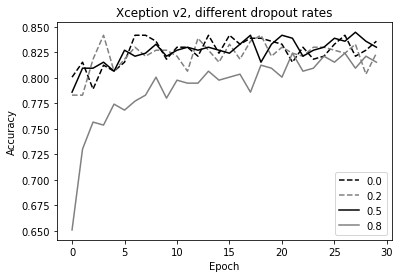

In [40]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, val00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, val02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, val05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, val08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout.svg')

plt.show()

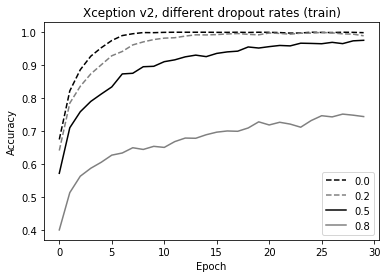

In [41]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, train00, color='black', linestyle='dashed', label='0.0')
plt.plot(epochs, train02, color='grey', linestyle='dashed', label='0.2')
plt.plot(epochs, train05, color='black', linestyle='solid', label='0.5')
plt.plot(epochs, train08, color='grey', linestyle='solid', label='0.8')


plt.title('Xception v2, different dropout rates (train)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')


plt.legend()

plt.savefig('xception_v2_dropout_train.svg')

plt.show()

## Data augmentation

In [27]:
validation_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

val_ds = validation_gen.flow_from_directory(
    "data/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 660 images belonging to 2 classes.


In [28]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 2637 images belonging to 2 classes.


In [29]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v3_{epoch:02d}_{val_accuracy:.3f}.h5",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history = model.fit(train_ds, epochs=50, validation_data=test_ds, callbacks=callbacks)

NameError: name 'make_model' is not defined

In [31]:
epochs = history.epoch
accuracy = history.history['val_accuracy']

NameError: name 'history' is not defined

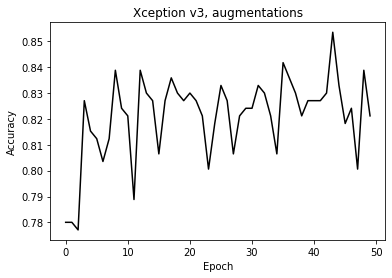

In [46]:
plt.figure(figsize=(6, 4))

plt.plot(epochs, accuracy, color='black', linestyle='solid')


plt.title('Xception v3, augmentations')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.savefig('xception_v3_aug.svg')

plt.show()

## Larger model

In [10]:
def make_model(learning_rate, droprate):
    base_model = ResNet50(
        weights='imagenet',
        input_shape=(224, 224, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(224, 224, 3))

    base = base_model(inputs, training=False)
    vector = keras.layers.GlobalAveragePooling2D()(base)

    inner = keras.layers.Dense(100, activation='relu')(vector)
    drop = keras.layers.Dropout(droprate)(inner)

    outputs = keras.layers.Dense(2)(drop)

    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    
    return model

In [11]:
image_size = (224, 224)
batch_size = 32

In [12]:
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    shear_range=10.0,
    zoom_range=0.1,
    horizontal_flip=True,  
)

train_ds = train_gen.flow_from_directory(
    "data/train",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 2637 images belonging to 2 classes.


In [13]:
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_ds = test_gen.flow_from_directory(
    "data/test",
    seed=1,
    target_size=image_size,
    batch_size=batch_size,
)

Found 660 images belonging to 2 classes.


In [14]:
model = make_model(learning_rate=0.001, droprate=0.2)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "ResNet_v4_large_{epoch:02d}_{val_accuracy:.3f}.keras",
        monitor="val_accuracy",
        save_best_only=True,
        mode='max'
    )
]

history_l = model.fit(train_ds, epochs=20, validation_data=test_ds, callbacks=callbacks)

Epoch 1/20


2025-12-31 17:48:35.410539: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-31 17:48:36.260284: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 106463232 exceeds 10% of free system memory.
2025-12-31 17:48:36.294151: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-31 17:48:36.456021: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.
2025-12-31 17:48:36.601306: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 102760448 exceeds 10% of free system memory.


83/83 ━━━━━━━━━━━━━━━━━━━━ 182s 2s/step - accuracy: 0.8187 - loss: 0.4061 - val_accuracy: 0.8606 - val_loss: 0.2967
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8680 - loss: 0.2928 - val_accuracy: 0.8167 - val_loss: 0.3869
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step - accuracy: 0.8809 - loss: 0.2594 - val_accuracy: 0.8803 - val_loss: 0.2853
Epoch 4/20
12/83 ━━━━━━━━━━━━━━━━━━━━ 2:00 2s/step - accuracy: 0.9167 - loss: 0.2034

KeyboardInterrupt: 

Let's test these models now! (see another notebook)